<div align="center">
<p align="center" style="width: 100%;">
    <img src="https://raw.githubusercontent.com/vlm-run/.github/refs/heads/main/profile/assets/vlm-black.svg" alt="VLM Run Logo" width="80" style="margin-bottom: -5px; color: #2e3138; vertical-align: middle; padding-right: 5px;"><br>
</p>
<p align="center"><a href="https://docs.vlm.run"><b>Website</b></a> | <a href="https://docs.vlm.run/"><b>API Docs</b></a> | <a href="https://docs.vlm.run/blog"><b>Blog</b></a> | <a href="https://discord.gg/AMApC2UzVY"><b>Discord</b></a>
</p>
<p align="center">
<a href="https://discord.gg/AMApC2UzVY"><img alt="Discord" src="https://img.shields.io/badge/discord-chat-purple?color=%235765F2&label=discord&logo=discord"></a>
<a href="https://twitter.com/vlmrun"><img alt="Twitter Follow" src="https://img.shields.io/twitter/follow/vlmrun.svg?style=social&logo=twitter"></a>
</p>
</div>

Welcome to **[VLM Run Cookbooks](https://github.com/vlm-run/vlmrun-cookbook)**, a comprehensive collection of examples and notebooks demonstrating the power of structured visual understanding using the [VLM Run Platform](https://app.vlm.run). 

## 🎨 MCP Showcase

This guide walks through our [new MCP server](https://docs.vlm.run/mcp/introduction) and all the tools it provides to date. For a more detailed overview of the MCP server, please refer to the [MCP documentation](https://docs.vlm.run/mcp/introduction) and the [tools reference](https://docs.vlm.run/mcp/tools/overview).

## Prerequisites

* Python 3.9+
* VLM Run API key (get one at [app.vlm.run](https://app.vlm.run))
* OpenAI SDK and API key

In [ ]:
! pip install vlmrun openai --upgrade --quiet

## MCP Server Setup

First, let's connect to our MCP server and list all the available tools. Our MCP server is remotely hosted on `https://mcp.vlm.run` and currently authenticated using an API key. You can head over to our [API keys](https://app.vlm.run/dashboard/settings/api_keys) page to get your full authenticated MCP server URL.

For the purpose of this demo, let's use the OpenAI SDK to connect to our MCP server. In order to test our connection, let's list all the available tools in a neatly formatted markdown table.

In [129]:
import os
import openai
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", None)
if OPENAI_API_KEY is None:
    raise ValueError("OPENAI_API_KEY is not set")

VLMRUN_API_KEY = os.getenv("VLMRUN_API_KEY", None)
if VLMRUN_API_KEY is None:
    raise ValueError("VLMRUN_API_KEY is not set")


# Initialize the OpenAI client
client = openai.Client(api_key=OPENAI_API_KEY)

# Fill in the MCP base URL from the API keys page
# https://app.vlm.run/dashboard/settings/api_keys
MCP_BASE_URL = f"https://mcp.vlm.run/{VLMRUN_API_KEY}/sse"

# We'll use the OpenAI SDK to connect to our MCP server.
result = client.responses.create(
    model="gpt-4.1",
    tools=[
        {
            "type": "mcp",
            "server_label": "vlmrun-mcp-server",
            "server_url": MCP_BASE_URL,
            "require_approval": "never",
        },
    ],
    input="List all the available tools in a neatly formatted markdown table",
)
print(result.output_text)

Here is a neatly formatted markdown table listing all the available tools (API endpoints) along with a brief description:

| Tool Name                                      | Description                                                                                       |
|------------------------------------------------|---------------------------------------------------------------------------------------------------|
| put_image_url                                  | Uploads an image from a URL and returns an image reference.                                       |
| put_image                                      | Uploads an image from base64 and returns an image reference.                                      |
| put_file_url                                   | Uploads a file from a URL and returns a file reference.                                           |
| preview_file_url                               | Gets a preview (or download) URL for an object reference (file/image/au

## Defining a basic LLM agent with [VLM Run MCP](https://docs.vlm.run/mcp/introduction) tools

Let's define a basic visual workflow that can understand user-intent via natural language input, and have the LLM agent build a visual AI workflow on-the-fly to process the input images. Unlike standalone LLMs or VLMs, here we'll show how the LLM agent will be able to leverage our VLM Run MCP tools in order to accomplish certain tasks that are typically not possible with standalone multi-modal LLMs. 

In [141]:
from pydantic import BaseModel, Field

class ReasoningStep(BaseModel):
    tool_id: str = Field(..., description="The tool used in this step")
    reasoning: str = Field(..., description="The reasoning for this step")

class ToolCallStep(BaseModel):
    tool_id: str = Field(..., description="The tool used in this step")
    reasoning: str = Field(..., description="A short description of the reasoning for this tool call")

class Response(BaseModel):
    reasoning_steps: list[ReasoningStep] = Field(..., description="The reasoning steps for the response")
    tool_calls: list[ToolCallStep] = Field(..., description="The sequence of tool calls for the response to arrive at the final answer")
    result: str = Field(..., description="The final result of the response")
    url: str = Field(..., description="The preview URL of the image, in the format https://mcp.vlm.run/files/<file_id>")

def process(prompt: str) -> Response:
    """The process function wraps the OpenAI Responses API that 
    executes multiple tool calls to accomplish the user-intent, and finally 
    parses the resulting response into a structured format."""
    result = client.responses.parse(
        model="gpt-4.1",
        tools=[
            {
                "type": "mcp",
                "server_label": "vlmrun-mcp-server",
                "server_url": MCP_BASE_URL,
                "require_approval": "never",
            },
        ],
        input=prompt,
        text_format=Response
    )
    return result.output_parsed

## Use-cases

Now, let's go ahead and define a few use-cases where the user can provide a language instruction along with image references.

In [143]:

class Example(BaseModel):
    name: str
    prompt: str
    inputs: dict[str, str]


EXAMPLES = [
    # image-workflows (basic)
    Example(
        name="load-image-and-preview",
        prompt="Load this image ({url}) and preview it.",
        inputs={"url": "https://storage.googleapis.com/vlm-data-public-prod/hub/examples/media.tv-news/finance_bb_3_speakers.jpg"}
    ),
    Example(
        name="face-detection",
        prompt="Detect the faces in this image ({url}). Overlay the detected faces on the image and preview it.",
        inputs={"url": "https://cdn.mos.cms.futurecdn.net/Yvs83nR9GrDk9bq4Weq5eZ.jpg"}
    ),
    Example(
        name="face-detection-and-blurring",
        prompt="Load this image ({url}) and detect all the faces in the image, blur them, and overlay the detected faces on the blurred image, and return the preview URL of the blurred image. ",
        inputs={"url": "https://storage.googleapis.com/vlm-data-public-prod/hub/examples/media.tv-news/finance_bb_3_speakers.jpg"}
    ),
    Example(
        name="object-detection",
        prompt="Load this image ({url}) and detect any objects or items in the image, and return the resulting image preview URL.",
        inputs={"url": "https://github.com/autonomi-ai/nos/blob/main/nos/test/test_data/test.jpg?raw=true"}
    ),
    Example(
        name="qr-code-detection",
        prompt="Load this image ({url}) and detect any QR codes in the image, and visualize the bounding box locations of each QR code. Also return the QR code content. ",
        inputs={"url": "https://storage.googleapis.com/vlm-data-public-prod/hub/examples/image.agent/qr-code-screen.jpg"}
    ),
    Example(
        name="crop-right-face-and-preview",
        prompt="Load this image ({url}), detect all the faces in the image, crop the middle face, and preview the cropped face and provide a brief description of the cropped face. ",
        inputs={"url": "https://storage.googleapis.com/vlm-data-public-prod/hub/examples/media.tv-news/finance_bb_3_speakers.jpg"}
    ),
    # document-workflows
    Example(
        name="extract-the-invoice-and-ground-details",
        prompt="Load this invoice ({url}), extract only these details: (invoice number, subtotal, total amount, date, etc.). Extract the bounding boxes or grounding information and visualize the invoice with the extracted details. ",
        inputs={"url": "https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.invoice/invoice_1.jpg"}
    ),
    Example(
        name="redact-doc-pii",
        prompt="Can you redact all the personally identifiable information of the patient (name, address, DOB, phone number, email, etc.) in the following image ({url}) and provide a link to the redacted image.",
        inputs={"url": "https://www.carepatron.com/files/physical-therapy-referral-form-sample-template.jpg"}
    ),
]

## Let's execute!

Now that we have defined the individual use-cases, let's execute it and see how well our LLM agent equipped with the VLM Run MCP tools can accomplish the tasks!

In [144]:
import warnings
from typing import Any
from tqdm import tqdm

# Drop any UserWarning in pydantic
warnings.filterwarnings("ignore", category=UserWarning)

# Define the example with response
class ExampleWithResponse(BaseModel):
    input: Example
    response: Any | None = None
    error_msg: str | None = None


# Process all the examples
responses = []
for ex in tqdm(EXAMPLES, desc="Processing examples"):
    try:
        # Format the prompt with the inputs
        ex.prompt = ex.prompt.format(**ex.inputs)
        # Process the prompt
        response = process(ex.prompt)
        # Add the response to the list
        responses.append(ExampleWithResponse(input=ex, response=response, error_msg=None))
    except Exception as e:
        responses.append(ExampleWithResponse(input=ex, response=None, error_msg=str(e)))
        print(f"Error: {e}")

Processing examples: 100%|██████████| 8/8 [03:40<00:00, 27.51s/it]


Let's check the response of all the visual agent workflows we just created.

In [145]:
import pandas as pd

df = pd.DataFrame([r.model_dump(mode="json") for r in responses])
df = pd.concat([pd.json_normalize(df["input"]), pd.json_normalize(df["response"])], axis=1)
df

name  \
0                  load-image-and-preview   
1                          face-detection   
2             face-detection-and-blurring   
3                        object-detection   
4                       qr-code-detection   
5             crop-right-face-and-preview   
6  extract-the-invoice-and-ground-details   
7                          redact-doc-pii   

                                              prompt  \
0  Load this image (https://storage.googleapis.co...   
1  Detect the faces in this image (https://cdn.mo...   
2  Load this image (https://storage.googleapis.co...   
3  Load this image (https://github.com/autonomi-a...   
4  Load this image (https://storage.googleapis.co...   
5  Load this image (https://storage.googleapis.co...   
6  Load this invoice (https://storage.googleapis....   
7  Can you redact all the personally identifiable...   

                                          inputs.url  \
0  https://storage.googleapis.com/vlm-data-public...   
1  https://cdn.mos.cms.futurecdn.net/Yvs83nR9GrDk...   
2  https://storage.googleapis.com/vlm-data-public...   
3  https://github.com/autonomi-ai/nos/blob/main/n...   
4  https://storage.googleapis.com/vlm-data-public...   
5  https://storage.googleapis.com/vlm-data-public...   
6  https://storage.googleapis.com/vlm-data-public...   
7  https://www.carepatron.com/files/physical-ther...   

                                     reasoning_steps  \
0  [{'tool_id': 'mcp_vlmrun-mcp-server.put_image_...   
1  [{'tool_id': 'mcp_vlmrun-mcp-server.put_image_...   
2  [{'tool_id': 'put_image_url', 'reasoning': 'Lo...   
3  [{'tool_id': 'put_image_url', 'reasoning': 'Lo...   
4  [{'tool_id': 'put_image_url', 'reasoning': 'Lo...   
5  [{'tool_id': 'put_image_url', 'reasoning': 'Lo...   
6  [{'tool_id': 'mcp_vlmrun-mcp-server.put_image_...   
7  [{'tool_id': 'mcp_vlmrun-mcp-server.put_image_...   

                                          tool_calls  \
0  [{'tool_id': 'mcp_vlmrun-mcp-server.put_image_...   
1  [{'tool_id': 'mcp_vlmrun-mcp-server.put_image_...   
2  [{'tool_id': 'put_image_url', 'reasoning': 'To...   
3  [{'tool_id': 'put_image_url', 'reasoning': 'Ne...   
4  [{'tool_id': 'put_image_url', 'reasoning': 'Ne...   
5  [{'tool_id': 'put_image_url', 'reasoning': 'To...   
6  [{'tool_id': 'mcp_vlmrun-mcp-server.put_image_...   
7  [{'tool_id': 'mcp_vlmrun-mcp-server.put_image_...   

                                              result  \
0  The image has been loaded and is previewed below.   
1  All detected faces in the image are now overla...   
2  The image has been processed: all faces are bl...   
3  Objects detected in the image include a bench ...   
4  A QR code was detected and visualized on the p...   
5  The cropped face previewed is of a young woman...   
6  Extracted invoice details have been visualized...   
7  All personally identifiable information (PII) ...   

                                  url  
0  https://mcp.vlm.run/files/img_4c11  
1  https://mcp.vlm.run/files/img_c004  
2  https://mcp.vlm.run/files/img_3151  
3  https://mcp.vlm.run/files/img_20c1  
4  https://mcp.vlm.run/files/img_9445  
5  https://mcp.vlm.run/files/img_9362  
6  https://mcp.vlm.run/files/img_4e72  
7  https://mcp.vlm.run/files/img_4ac5

## Show me the results!

Enough talking - let's see the results!


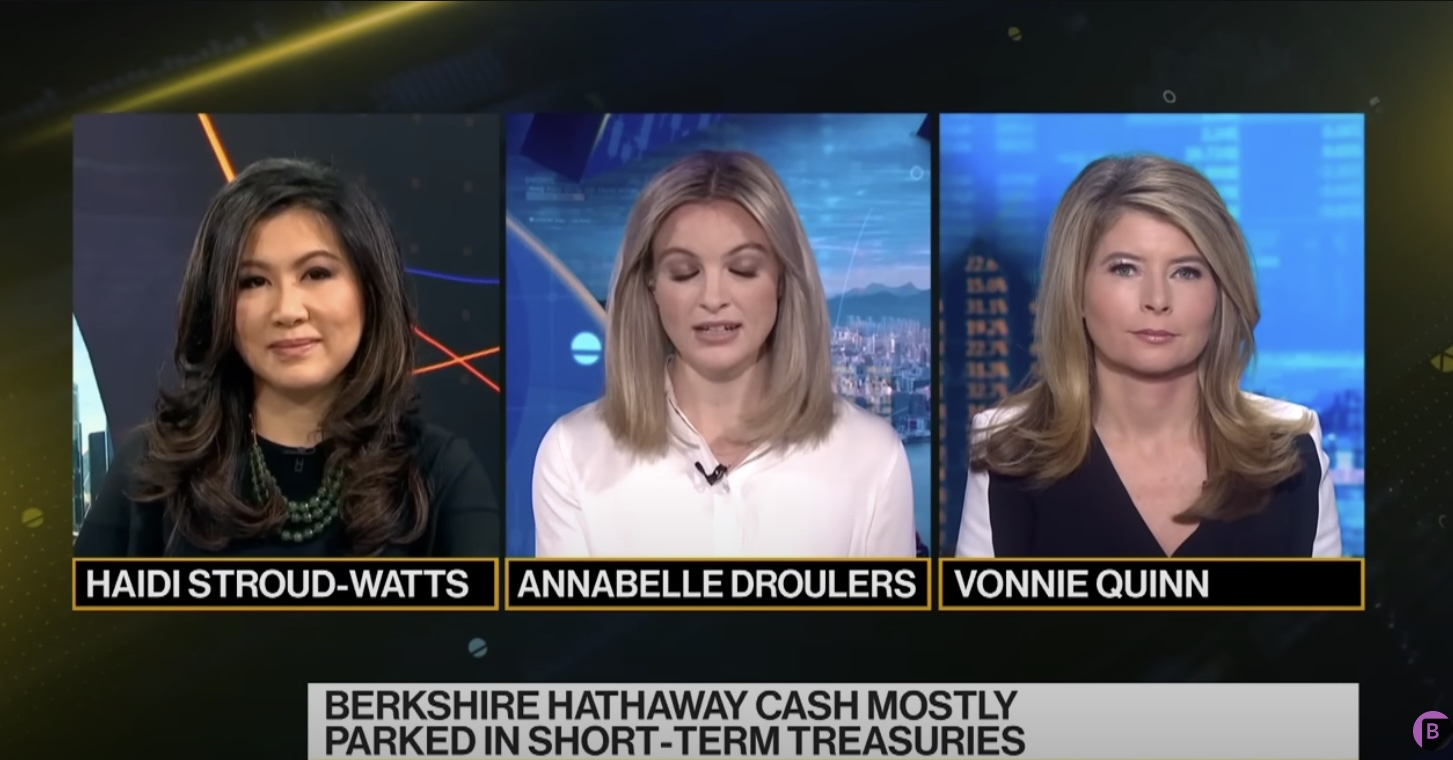
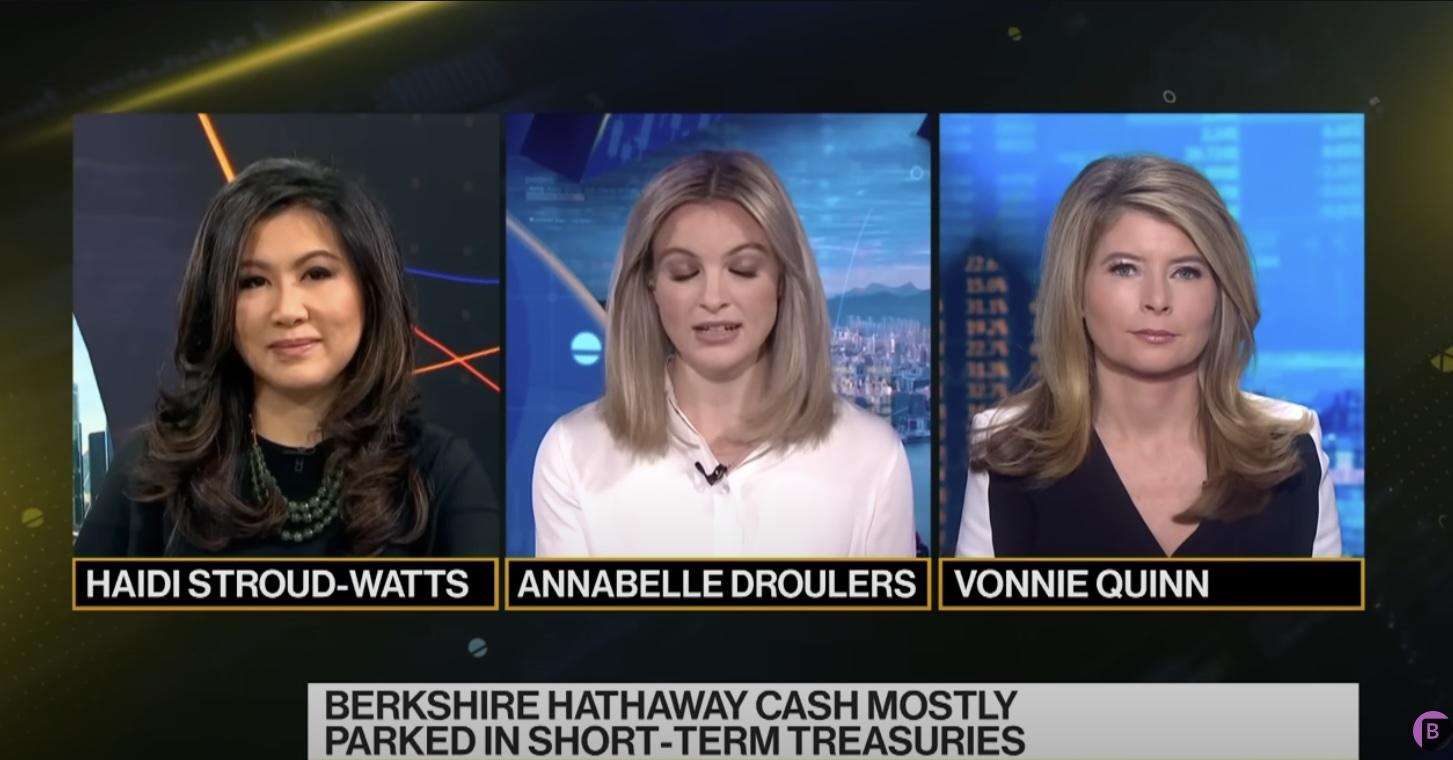
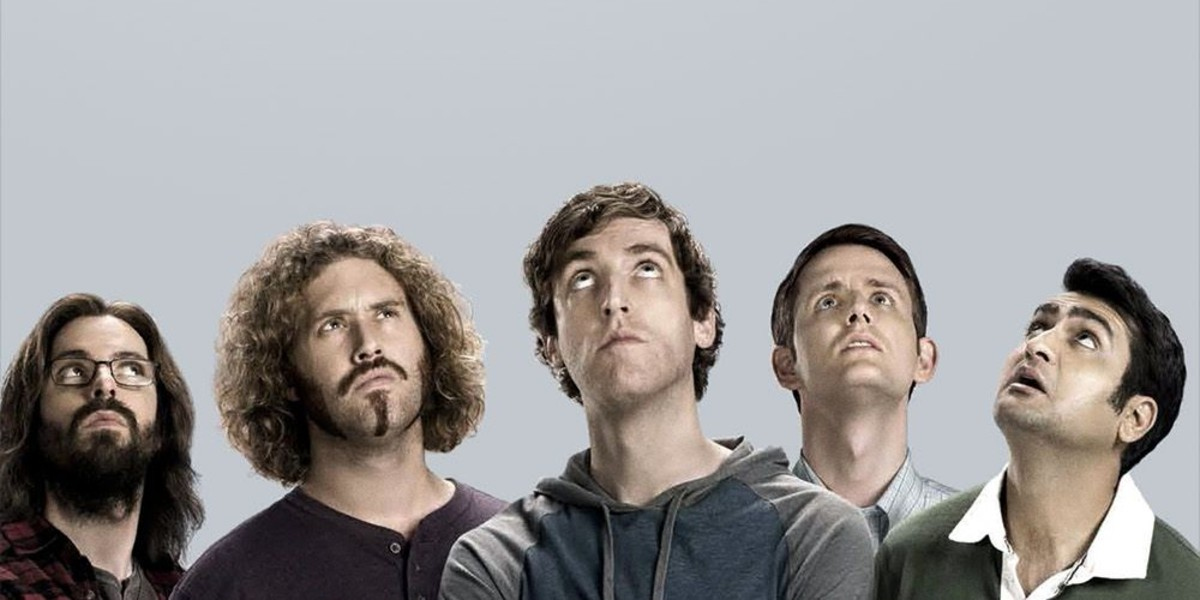
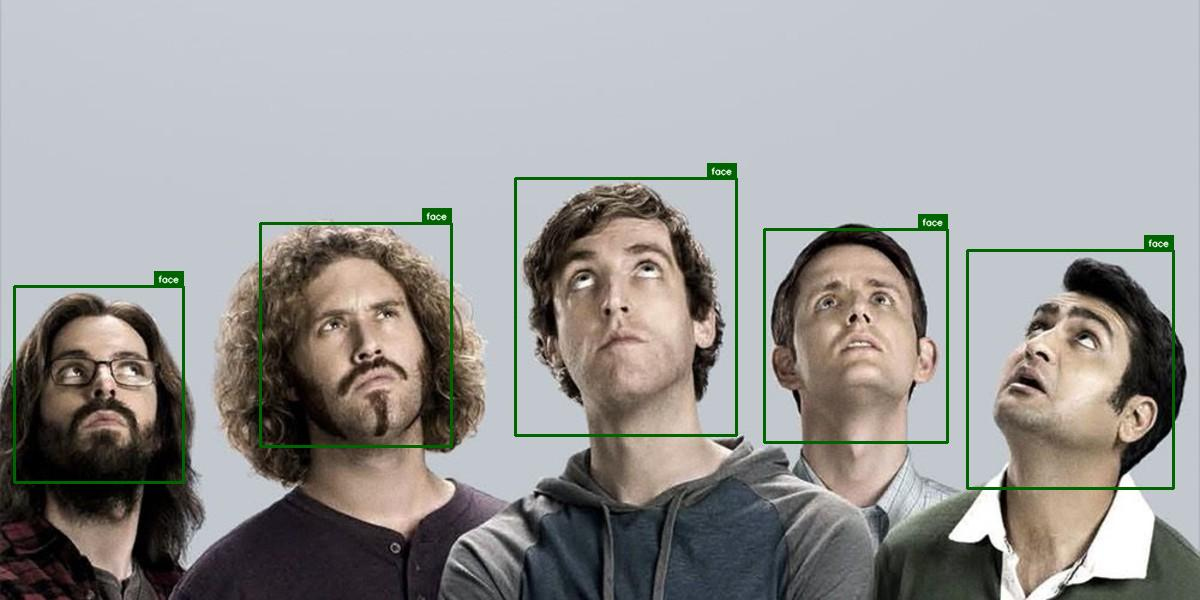
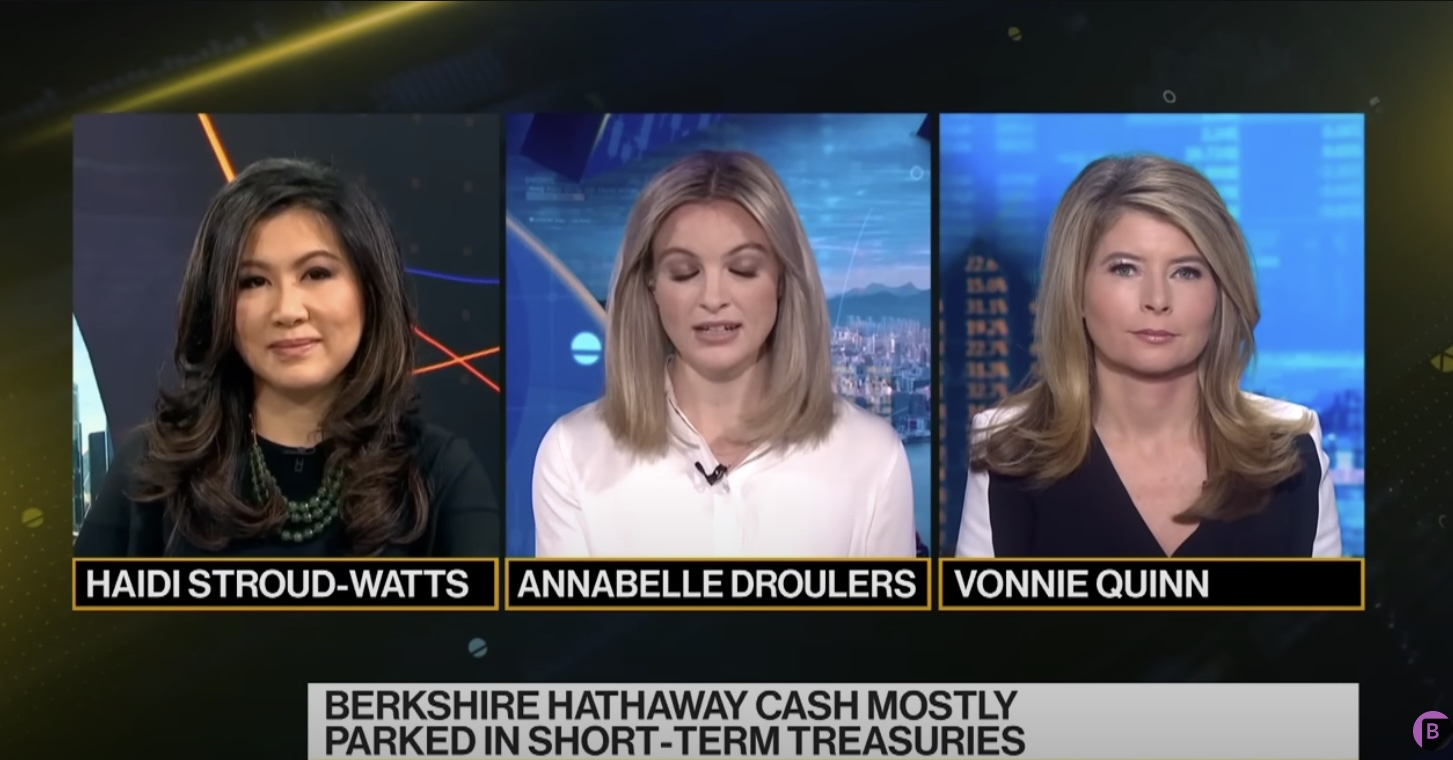
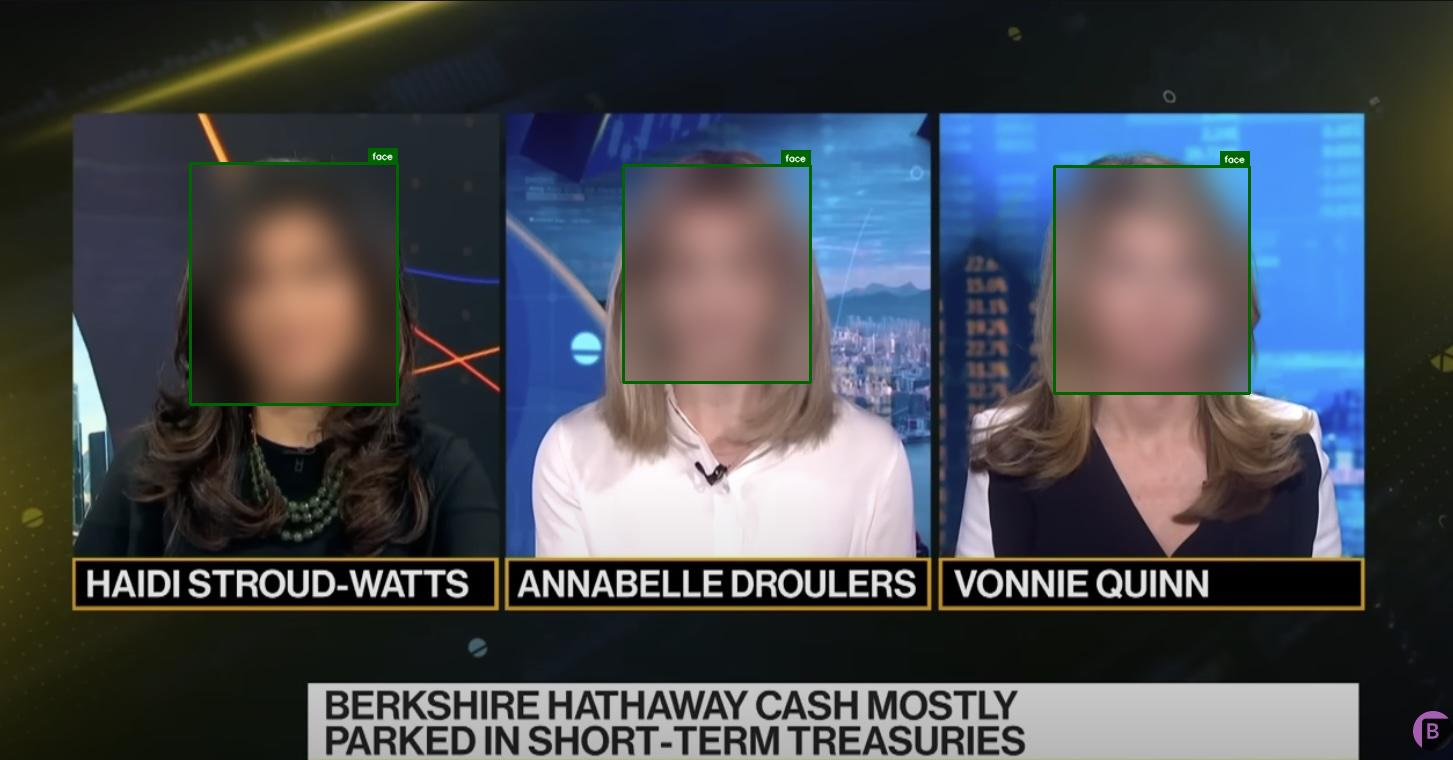
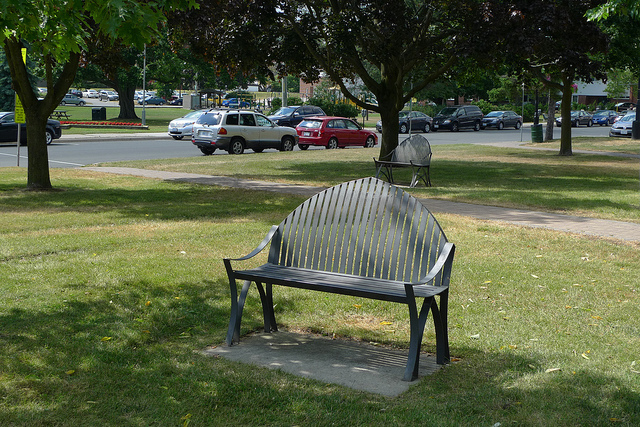
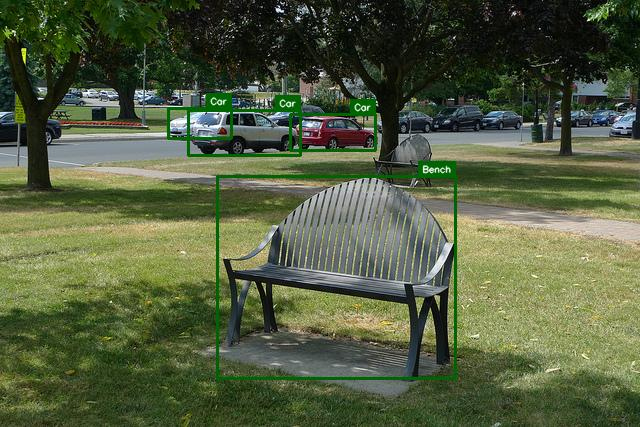
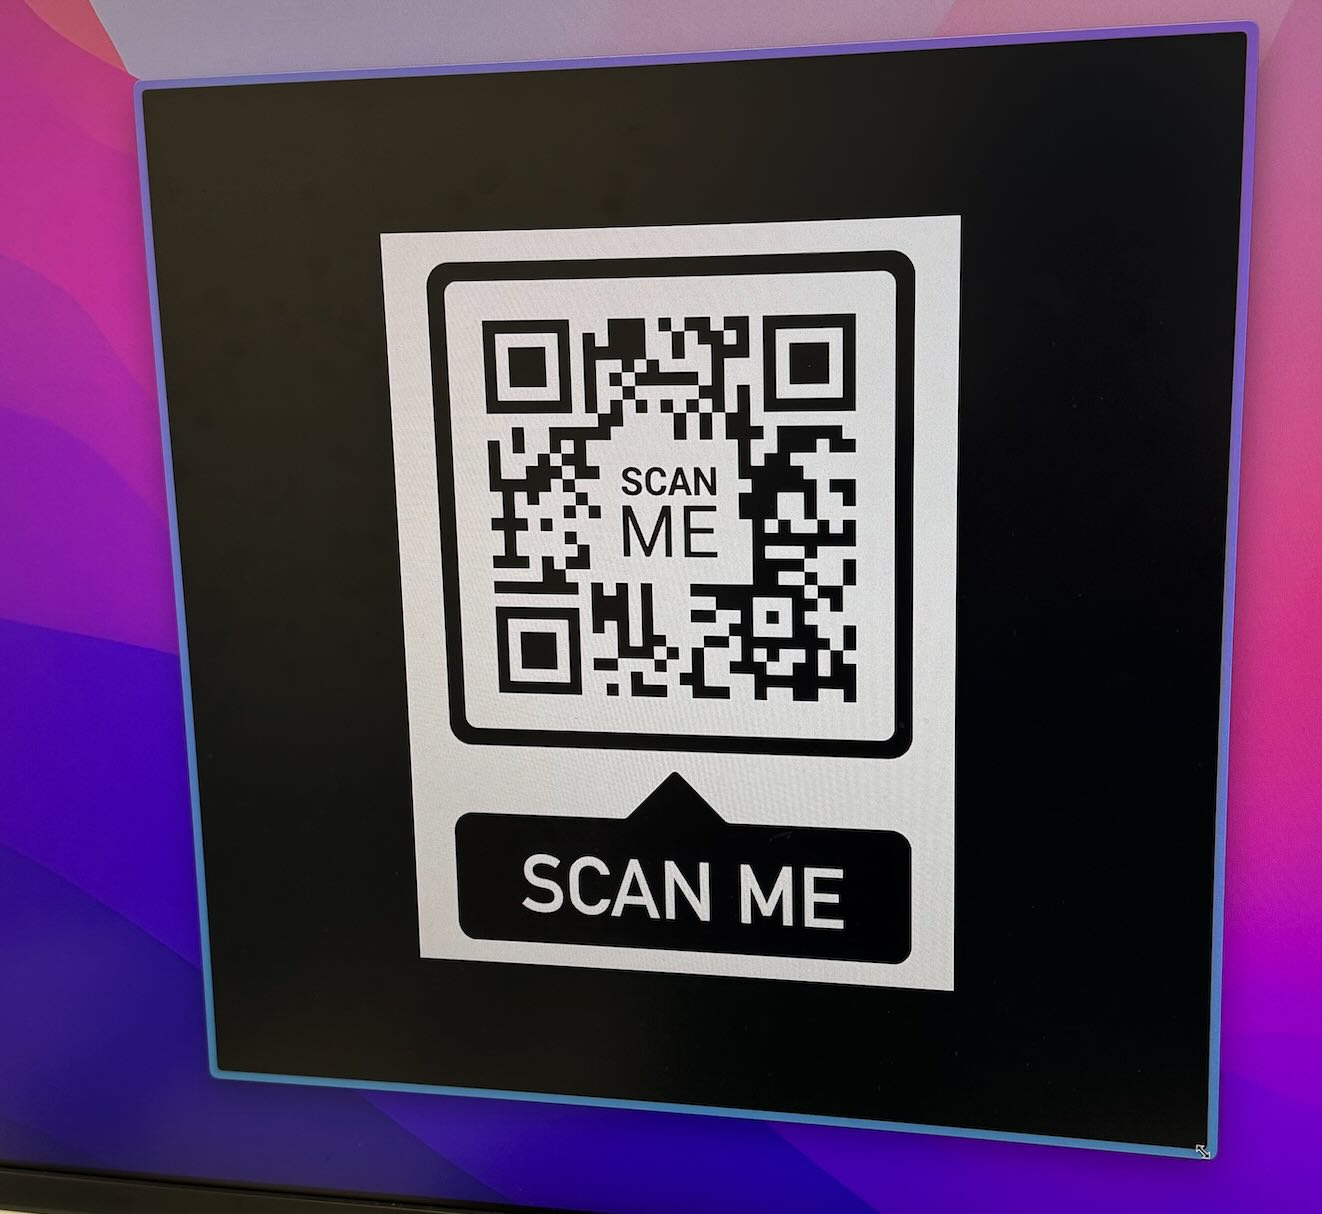
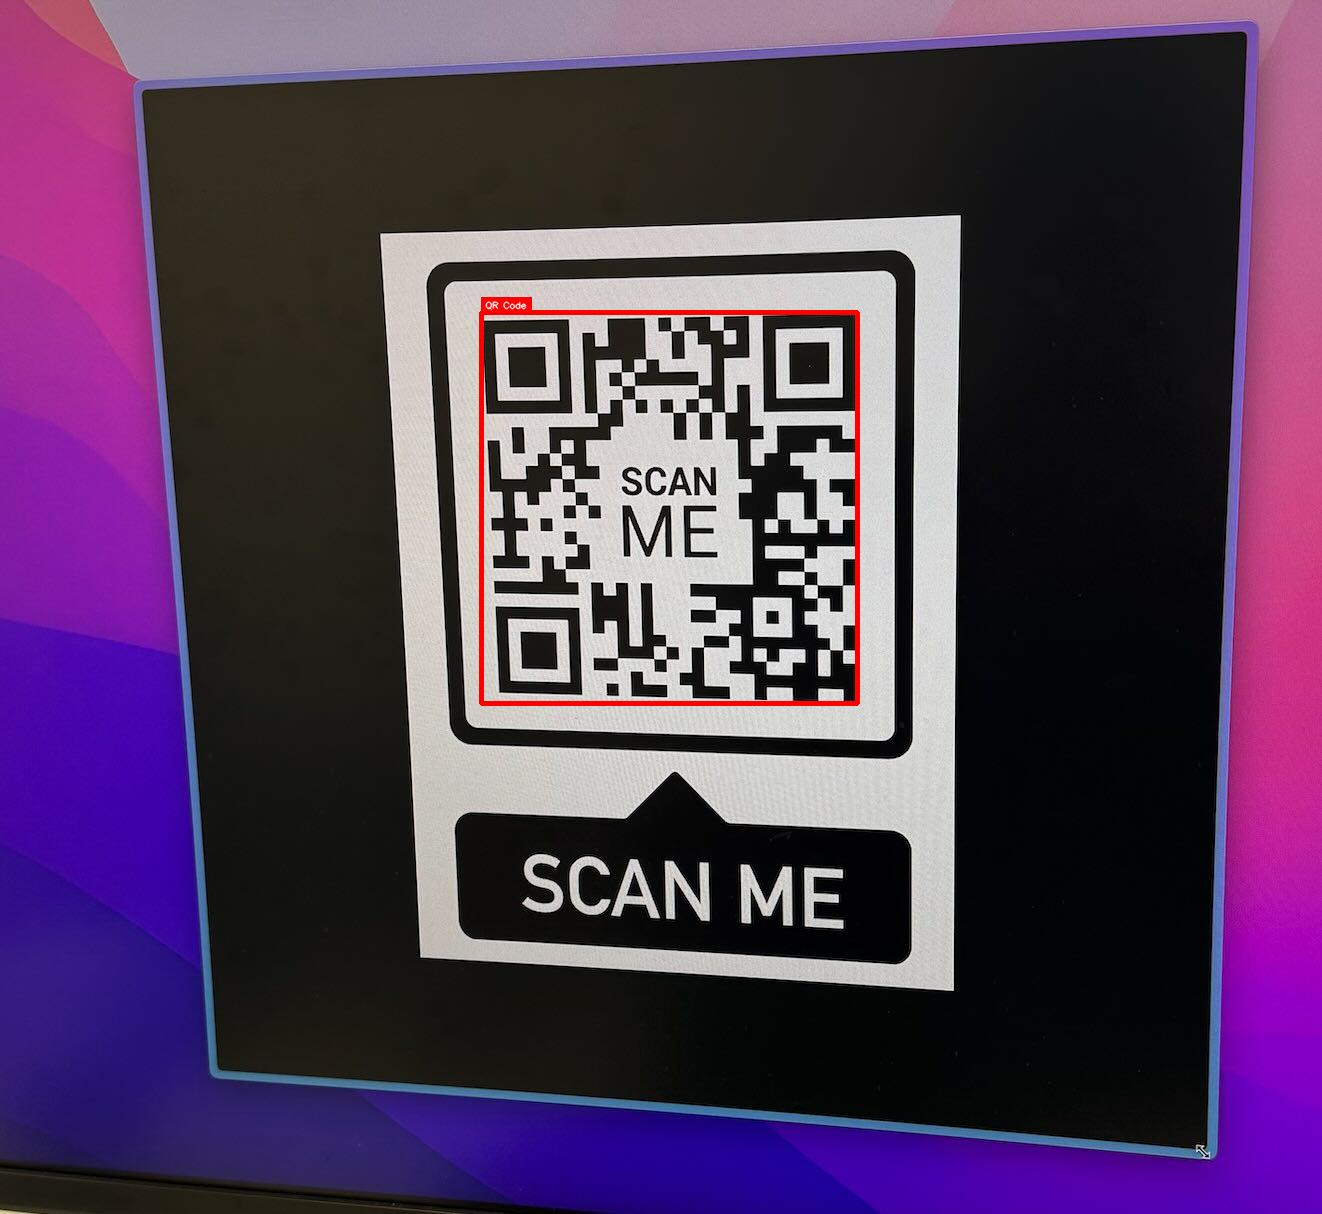
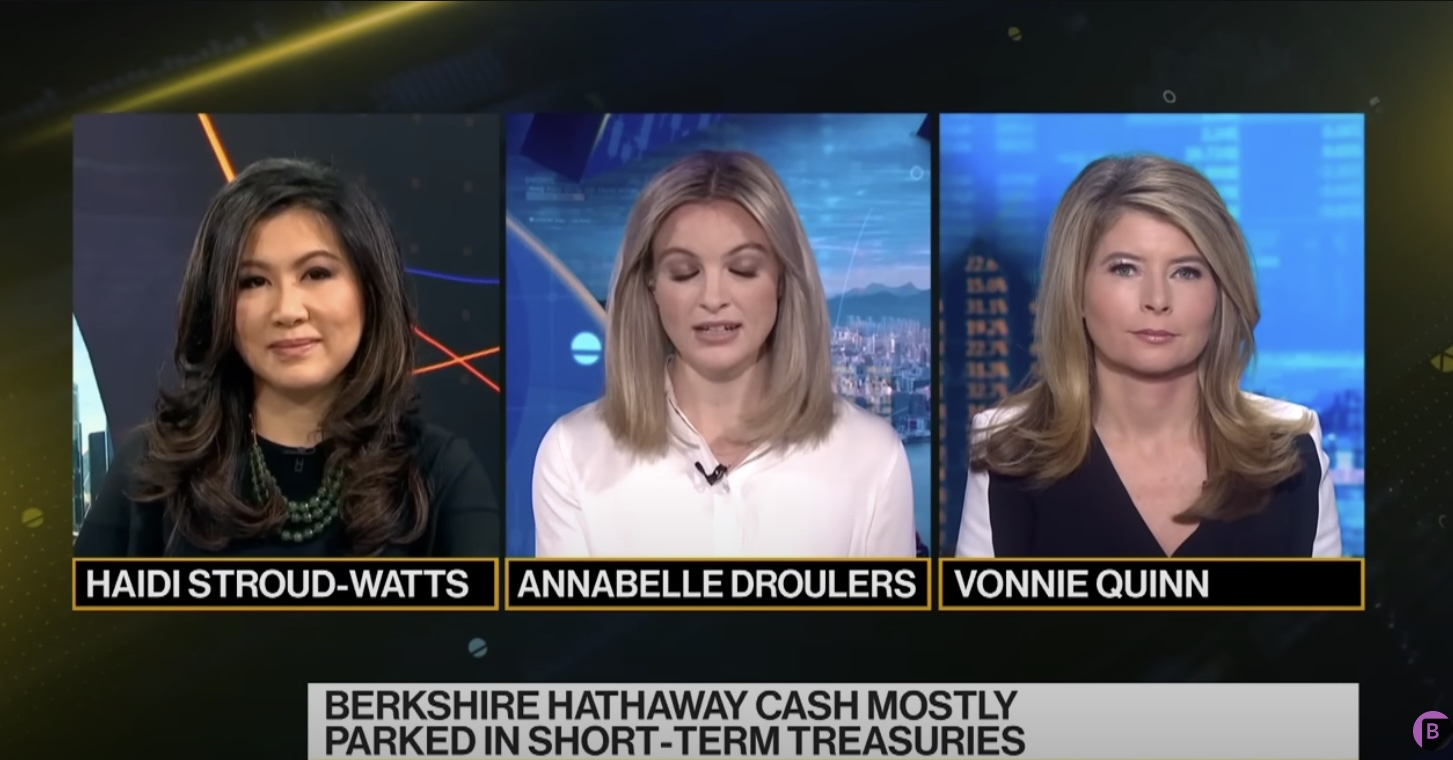
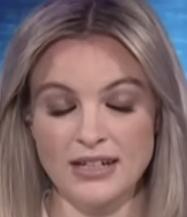
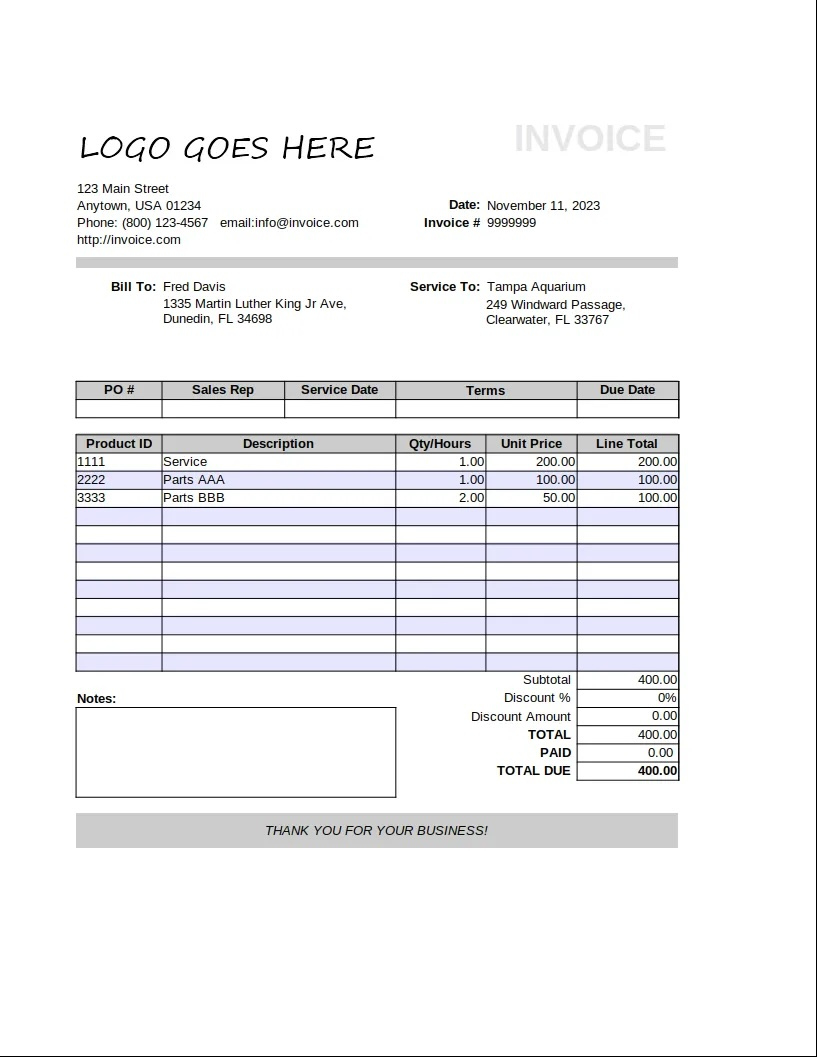
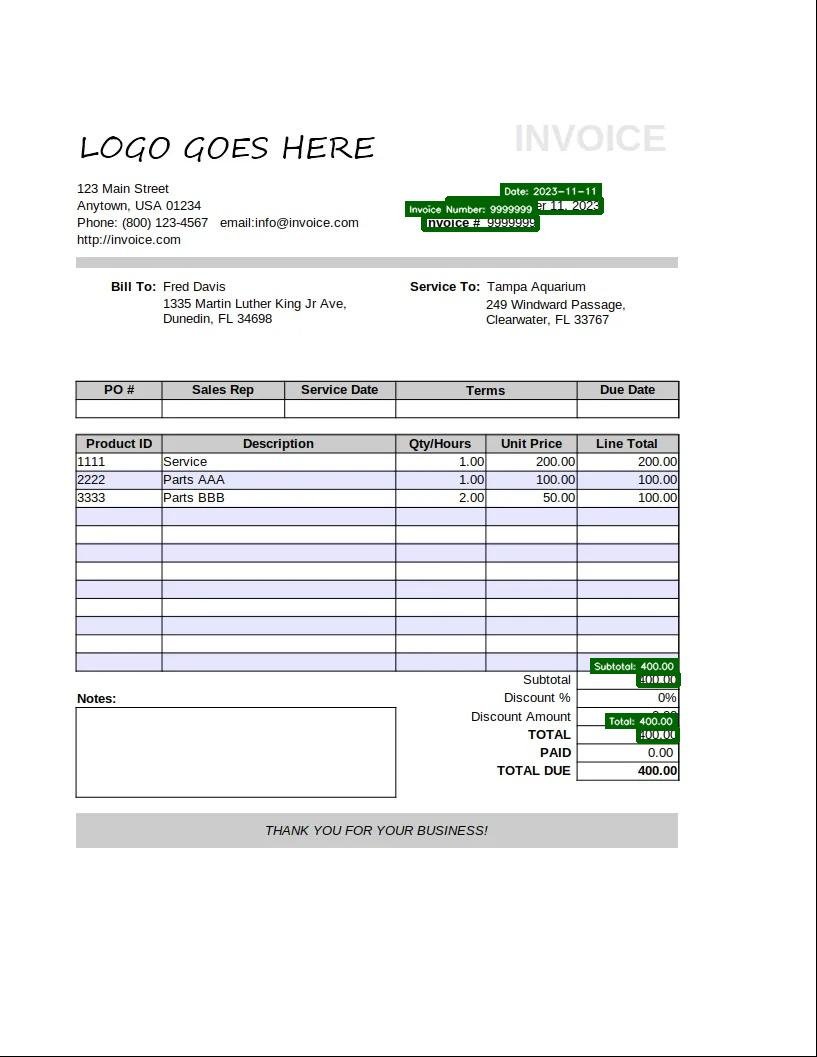
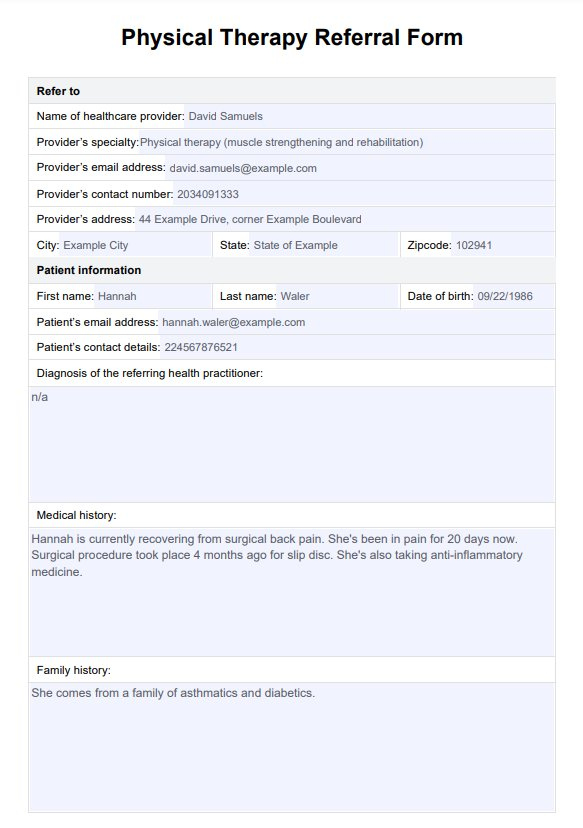
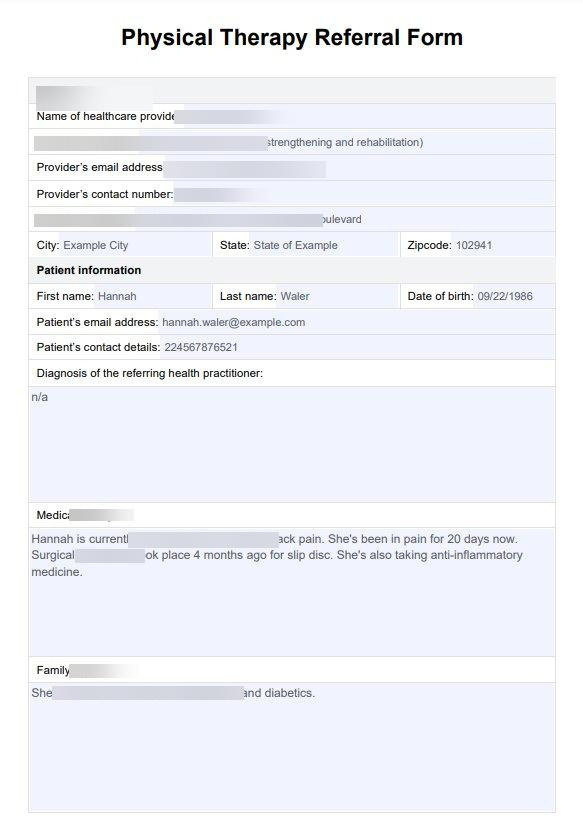

In [ ]:
from IPython.display import HTML, display

formatters = {
    "prompt": lambda x: f'<div style="width: 300px; word-wrap: break-word;">{x}</div>',
    "result": lambda x: f'<div style="width: 300px; word-wrap: break-word;">{x}</div>',
    "inputs.url": lambda x: f"<img src={x} width='500'>",
    "url": lambda x: f"<img src={x} width='500'>",
}

cols = ["name", "prompt", "result", "inputs.url", "url"]
html = df[cols].to_html(formatters=formatters, escape=False)
display(HTML(html))

### 💡 Pro Tips for Using VLM MCP tools

1. Familiarize yourself with the [tools and the current capabilities](https://docs.vlm.run/mcp/tools/overview)
   - Consider working with individual images and fewer tools first to make sure the workflow is working as expected.
   - Start building and extending the workflow, one new tool at a time. 
   - Provide any relevant guidance to the workflow with the tool capability, and avoid explicitly calling out tool-names.

2. Best Practices:
   - Ensure good image quality
   - Validate outputs with structured responses (Pydantic), if possible

3. Common Use Cases:
   - Document Processing: Invoices, resumes, IDs
   - Healthcare: Insurance cards, patient intake forms
   - Sports & Media: Game analysis, news content
   - Retail: Product cataloging, ad analysis
   - Aerospace: Satellite imagery analysis


### Quick Links

- 📚 Docs: [VLM Run MCP Docs](https://docs.vlm.run/mcp/introduction)
- 🌐 Website: [VLM Run MCP](https://vlm.run/mcp)